In [ ]:
import pandas as pd
import re
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, GPT2LMHeadModel, GPT2Tokenizer
import networkx as nx
from sklearn.cluster import KMeans

In [ ]:
neutral_data = pd.DataFrame({
    'Stressor': [
        'Updated report', 'Weather Update', 'Channel', 'Statement', 'Hurricane Report', 'Weather Channel',
        'Updates', 'Latest Updates', 'Information', 'Weatherforecast', 'National Updates', 'Weather Report',
        'Statement Report', 'Latest Information', 'Damages Updates', 'Latest Report', 'Landfall Updates', 'Storm Report',
        'Safety Statement', 'Alerts'
    ],
    'Term 1': ['report', 'weather', 'weather', 'power', 'report', 'weather', 'report', 'update', 'update', 'weather', 'update', 'update', 'update', 'report', 'update', 'update', 'update', 'wind', 'update', 'update'],
    'Term 2': ['update', 'see', 'channel', 'en', 'weather', 'report', 'prepare', 'report', 'strengthen', 'information', 'report', 'wind', 'latest', 'corpu', 'latest', 'storm', 'landfall', 'weather', 'come', 'give'],
    'Term 3': ['video', 'update', 'coverage', 'weather', 'storm', 'stay', 'effort', 'follow', 'pm', 'forecast', 'txwx', 'weather', 'statement', 'information', 'major', 'downgrade', 'latest', 'sustaine', 'center', 'friday'],
    'Term 4': ['track', 'bad', 'blog', 'update', 'hurricane', 'channel', 'jim', 'latest', 'storm', 'best', 'periscope', 'report', 'pm', 'christi', 'please', 'tropical', 'make', 'report', 'storm', 'abbott'],
    'Term 5': ['special', 'report', 'geek', 'outage', 'damage', 'people', 'multiple', 'catastrophic', 'cdt', 'aug', 'center', 'cat', 'watch', 'near', 'water', 'latest', 'weather', 'update', 'ashore', 'break'],
    'Term 6': ['alert', 'could', 'video', 'report', 'rain', 'watch', 'acosta', 'flood', 'cat', 'update', 'add', 'kt', 'report', 'update', 'damage', 'saturday', 'service', 'storm', 'upgrade', 'greg'],
    'Term 7': ['lik', 'story', 'lik', 'wake', 'southeast', 'go', 'apparently', 'rockport', 'track', 'know', 'weather', 'stay', 'day', 'tx', 'stay', 'flood', 'national', 'maximum', 'weather', 'school'],
    'Term 8': ['price', 'rain', 'due', 'el', 'lash', 'pray', 'ignore', 'expect', 'aug', 'last', 'jeffpiotrowski', 'mov', 'gulf', 'landfall', 'br', 'head', 'storm', 'eye', 'noaa', 'alert'],
    'Term 9': ['satellite', 'top', 'condition', 'statement', 'help', 'due', 'update', 'damage', 'wind', 'predict', 'national', 'tonight', 'et', 'latest', 'wind', 'toward', 'expect', 'max', 'safety', 'august'],
    'Term 10': ['watch', 'latest', 'severe', 'atlntico', 'wind', 'reporter', 'continue', 'due', 'information', 'beach', 'mb', 'without', 'make', 'make', 'weather', 'made', 'made', 'cat', 'statement', 'gov']
})

neutral_data['Description'] = neutral_data.apply(lambda row: ' '.join(row[1:].astype(str)), axis=1)

negative_data = pd.DataFrame({
    'Stressor': [
        'Evacuation Plan', 'Concerns For Animals', 'Climate Change Policy', 'Safety Update', 'Danger', 'Warnings',
        'Response', 'Heavy Rain', 'Care of Family and Friend', 'Oil and Gas Price Rise', 'Helps', 'Fake News',
        'Flood', 'Pray', 'Intention', 'Catastrophic', 'Evacuation news', 'Landfall Preparedness', 'Mindsets', 'Downgrade'
    ],
    'Term 1': ['shelter', 'help', 'video', 'update', 'jeffpiotrowski', 'power', 'disaster', 'rain', 'stay', 'price', 'space', 'path', 'flood', 'prayer', 'im', 'flood', 'center', 'landfall', 'people', 'storm'],
    'Term 2': ['emergency', 'dog', 'lik', 'latest', 'wind', 'track', 'gulf', 'watch', 'everyone', 'prepare', 'station', 'look', 'hit', 'pray', 'get', 'catastrophic', 'national', 'make', 'pardon', 'wind'],
    'Term 3': ['evacuee', 'relief', 'change', 'report', 'periscope', 'follow', 'open', 'tx', 'please', 'ga', 'seen', 'like', 'coverage', 'affect', 'go', 'post', 'say', 'corpu', 'dont', 'strengthen'],
    'Term 4': ['free', 'food', 'climate', 'president', 'gust', 'story', 'border', 'eye', 'hope', 'oil', 'nasa', 'monitor', 'weather', 'path', 'hit', 'due', 'pm', 'storm', 'arpaio', 'cat'],
    'Term 5': ['offer', 'donate', 'show', 'disaster', 'day', 'top', 'first', 'rockport', 'friend', 'damage', 'international', 'david', 'house', 'thought', 'com', 'flee', 'forecast', 'christi', 'evacuate', 'break'],
    'Term 6': ['flood', 'cros', 'twitter', 'city', 'damag', 'without', 'patrol', 'water', 'good', 'major', 'cupola', 'camp', 'week', 'everyone', 'call', 'thousand', 'dog', 'near', 'think', 'toward'],
    'Term 7': ['help', 'bag', 'en', 'head', 'crazy', 'bear', 'brace', 'bring', 'path', 'san', 'victim', 'closely', 'channel', 'people', 'wait', 'storm', 'number', 'made', 'racist', 'threaten'],
    'Term 8': ['continue', 'support', 'satellite', 'wake', 'got', 'potential', 'major', 'wind', 'ready', 'governor', 'help', 'fake', 'mis', 'god', 'gonna', 'rainfall', 'one', 'hit', 'good', 'downgrad'],
    'Term 9': ['rescue', 'away', 'stream', 'great', 'last', 'map', 'face', 'barrel', 'family', 'rise', 'view', 'reporter', 'hope', 'go', 'like', 'intensifie', 'threat', 'could', 'would', 'year'],
    'Term 10': ['order', 'affect', 'approache', 'state', 'cat', 'update', 'natural', 'wall', 'roar', 'cause', 'donation', 'arriv', 'next', 'know', 'cant', 'upgrad', 'evacuat', 'southeast', 'coldplay', 'high']
})

negative_data['Description'] = negative_data.apply(lambda row: ' '.join(row[1:].astype(str)), axis=1)

positive_data = pd.DataFrame({
    'Stressor': [
        'Great Day', 'Relief', 'Good Day', 'Luck', 'Good Coverage', 'Love Everybody', 'Farewell', 'Good Vacation', 'Great Government',
        'Good Job/Help', 'Help Victim', 'Good Camp', 'Prayer', 'Good Message', 'Blessing', 'Birthday', 'Good Luck', 'Happy Weekend',
        'Wind', 'Pray'
    ],
    'Term 1': ['good', 'great', 'good', 'good', 'good', 'good', 'good', 'head', 'great', 'love', 'good', 'good', 'love', 'good', 'god', 'happy', 'good', 'weekend', 'good', 'pray'],
    'Term 2': ['weather', 'would', 'day', 'morn', 'far', 'luck', 'luck', 'good', 'state', 'job', 'luck', 'luck', 'prayer', 'luck', 'love', 'love', 'luck', 'great', 'great', 'good'],
    'Term 3': ['great', 'love', 'pardon', 'luck', 'im', 'everybody', 'prepare', 'vacation', 'work', 'great', 'love', 'great', 'stay', 'path', 'great', 'thank', 'get', 'good', 'make', 'everyone'],
    'Term 4': ['dog', 'help', 'friday', 'gulf', 'happy', 'bear', 'ahead', 'fac', 'city', 'good', 'help', 'tell', 'send', 'message', 'good', 'birthday', 'corpu', 'im', 'landfall', 'love'],
    'Term 5': ['show', 'could', 'happy', 'people', 'coverage', 'wish', 'heartless', 'luck', 'noth', 'director', 'victim', 'camp', 'path', 'people', 'hit', 'take', 'go', 'love', 'go', 'affect'],
    'Term 6': ['food', 'relief', 'great', 'wish', 'great', 'like', 'bid', 'great', 'gov', 'handle', 'better', 'david', 'everyone', 'everybody', 'bless', 'keep', 'th', 'happy', 'love', 'hop'],
    'Term 7': ['day', 'storm', 'arpaio', 'cat', 'watch', 'love', 'farewell', 'yell', 'monitor', 'bug', 'dont', 'way', 'thought', 'approache', 'help', 'great', 'look', 'let', 'impact', 'first'],
    'Term 8': ['side', 'change', 'real', 'storm', 'power', 'hit', 'shareblue', 'crassly', 'chance', 'laud', 'deserve', 'president', 'affect', 'say', 'thank', 'ill', 'people', 'go', 'still', 'day'],
    'Term 9': ['many', 'climate', 'im', 'love', 'get', 'bad', 'love', 'love', 'federal', 'agency', 'near', 'watch', 'good', 'said', 'die', 'wait', 'like', 'cover', 'morn', 'great'],
    'Term 10': ['bag', 'like', 'though', 'rain', 'keep', 'im', 'hear', 'stay', 'closely', 'help', 'go', 'doesnt', 'people', 'word', 'pray', 'away', 'say', 'look', 'wind', 'night']
})

positive_data['Description'] = positive_data.apply(lambda row: ' '.join(row[1:].astype(str)), axis=1)



Running on Negative Life Incidents Dataset...

Processing Negative Life Incidents Dataset with GNN-based Clustering...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

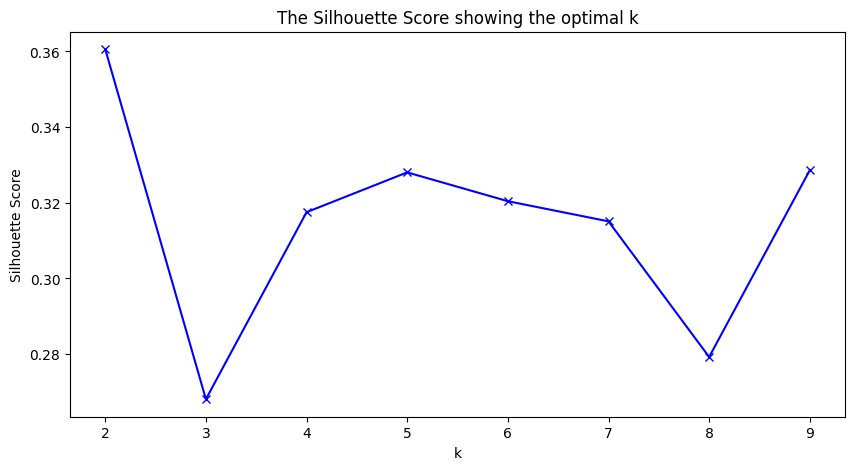

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Optimal number of clusters for GNN-based approach: 2
Epoch 1, Loss: 108028.6796875
Epoch 11, Loss: 8157.5283203125
Epoch 21, Loss: 1967.9364013671875
Epoch 31, Loss: 1246.49169921875
Epoch 41, Loss: 382.52801513671875
Epoch 51, Loss: 281.5980529785156
Epoch 61, Loss: 138.1554718017578
Epoch 71, Loss: 107.65852355957031
Epoch 81, Loss: 76.61930847167969
Epoch 91, Loss: 61.814571380615234
Epoch 100, Loss: 52.86210632324219


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GNN] Predicted Event Name for Event 0: a "crisis" in the US
Tweets in this group:
- space station seen nasa international cupola victim help view donation
- flood hit coverage weather house week channel mis hope next


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GNN] Predicted Event Name for Event 1: a "trend" in the news media
Tweets in this group:
- shelter emergency evacuee free offer flood help continue rescue order
- help dog relief food donate cros bag support away affect
- video lik change climate show twitter en satellite stream approache
- update latest report president disaster city head wake great state
- jeffpiotrowski wind periscope gust day damag crazy got last cat
- power track follow story top without bear potential map update
- disaster gulf open border first patrol brace major face natural
- rain watch tx eye rockport water bring wind barrel wall
- stay everyone please hope friend good path ready family roar
- price prepare ga oil damage major san governor rise cause
- path look like monitor david camp closely fake reporter arriv
- prayer pray affect path thought everyone people god go know
- im get go hit com call wait gonna like cant
- flood catastrophic post due flee thousand storm rainfall intensifie upgrad
- center nat

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 0: a "troll" and a troll is a person who is not a real person
Tweets in this group:
- video lik change climate show twitter en satellite stream approache
- stay everyone please hope friend good path ready family roar
- flood hit coverage weather house week channel mis hope next
- prayer pray affect path thought everyone people god go know
- people pardon dont arpaio evacuate think racist good would coldplay


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 1: a "crisis" in the sense that it is a situation that is not going to be resolved
Tweets in this group:
- update latest report president disaster city head wake great state
- power track follow story top without bear potential map update
- flood catastrophic post due flee thousand storm rainfall intensifie upgrad
- landfall make corpu storm christi near made hit could southeast


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 2: "the big picture" and is a good place to start
Tweets in this group:
- jeffpiotrowski wind periscope gust day damag crazy got last cat
- disaster gulf open border first patrol brace major face natural
- price prepare ga oil damage major san governor rise cause
- path look like monitor david camp closely fake reporter arriv
- im get go hit com call wait gonna like cant
- storm wind strengthen cat break toward threaten downgrad year high


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 3: a "water rescue" or "wall rescue"
Tweets in this group:
- shelter emergency evacuee free offer flood help continue rescue order
- rain watch tx eye rockport water bring wind barrel wall


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 4: a "dog" threat
Tweets in this group:
- help dog relief food donate cros bag support away affect
- space station seen nasa international cupola victim help view donation
- center national say pm forecast dog number one threat evacuat

Processing Negative Life Incidents Dataset with NMF...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 0: a "trend" in which the weather is changing and the people are changing
Tweets in this group:
- video lik change climate show twitter en satellite stream approache
- flood hit coverage weather house week channel mis hope next
- im get go hit com call wait gonna like cant
- flood catastrophic post due flee thousand storm rainfall intensifie upgrad
- landfall make corpu storm christi near made hit could southeast


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 1: a "white nationalist" conspiracy theory
Tweets in this group:
- stay everyone please hope friend good path ready family roar
- path look like monitor david camp closely fake reporter arriv
- prayer pray affect path thought everyone people god go know
- people pardon dont arpaio evacuate think racist good would coldplay


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 2: "the wind" and is not a technical term
Tweets in this group:
- jeffpiotrowski wind periscope gust day damag crazy got last cat
- rain watch tx eye rockport water bring wind barrel wall
- storm wind strengthen cat break toward threaten downgrad year high


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 3: a "threat" to the national security of the United States
Tweets in this group:
- shelter emergency evacuee free offer flood help continue rescue order
- help dog relief food donate cros bag support away affect
- space station seen nasa international cupola victim help view donation
- center national say pm forecast dog number one threat evacuat

[NMF] Predicted Event Name for Event 4: a "trend" in the news
Tweets in this group:
- update latest report president disaster city head wake great state
- power track follow story top without bear potential map update
- disaster gulf open border first patrol brace major face natural
- price prepare ga oil damage major san governor rise cause

Processing Negative Life Incidents Dataset with DBSCAN...

Processing Negative Life Incidents Dataset with Spectral Clustering...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 0: "the worst of the worst" and is not a new one
Tweets in this group:
- update latest report president disaster city head wake great state
- jeffpiotrowski wind periscope gust day damag crazy got last cat
- rain watch tx eye rockport water bring wind barrel wall
- price prepare ga oil damage major san governor rise cause
- im get go hit com call wait gonna like cant
- landfall make corpu storm christi near made hit could southeast
- people pardon dont arpaio evacuate think racist good would coldplay


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 1: a "good" or "bad" situation
Tweets in this group:
- help dog relief food donate cros bag support away affect
- stay everyone please hope friend good path ready family roar
- prayer pray affect path thought everyone people god go know


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 2: a "trend" in the news media
Tweets in this group:
- disaster gulf open border first patrol brace major face natural
- flood catastrophic post due flee thousand storm rainfall intensifie upgrad
- center national say pm forecast dog number one threat evacuat
- storm wind strengthen cat break toward threaten downgrad year high


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 3: a "crisis" in which the government is trying to "fix" the problem
Tweets in this group:
- shelter emergency evacuee free offer flood help continue rescue order
- space station seen nasa international cupola victim help view donation

[Spectral Clustering] Predicted Event Name for Event 4: a "trend" and not a trend
Tweets in this group:
- video lik change climate show twitter en satellite stream approache
- power track follow story top without bear potential map update
- path look like monitor david camp closely fake reporter arriv
- flood hit coverage weather house week channel mis hope next

Running on Neutral Life Incidents Dataset...

Processing Neutral Life Incidents Dataset with GNN-based Clustering...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

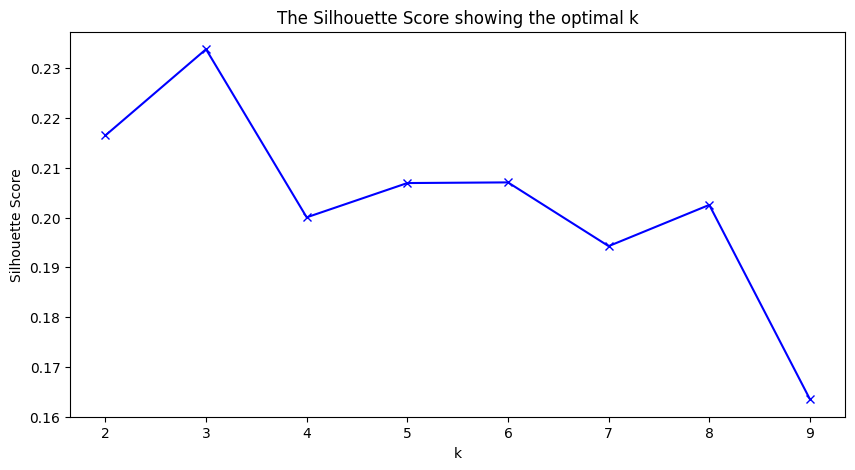

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Optimal number of clusters for GNN-based approach: 3
Epoch 1, Loss: 15503.4453125
Epoch 11, Loss: 1685.9859619140625
Epoch 21, Loss: 375.52325439453125
Epoch 31, Loss: 133.77859497070312
Epoch 41, Loss: 81.51066589355469
Epoch 51, Loss: 30.707557678222656
Epoch 61, Loss: 19.405651092529297
Epoch 71, Loss: 13.56304931640625
Epoch 81, Loss: 11.09157943725586
Epoch 91, Loss: 9.577641487121582
Epoch 100, Loss: 8.459728240966797


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GNN] Predicted Event Name for Event 0: a "topical" topic
Tweets in this group:
- power en weather update outage report wake el statement atlntico
- report weather storm hurricane damage rain southeast lash help wind
- weather information forecast best aug update know last predict beach
- update landfall latest make weather service national storm expect made
- wind weather sustaine report update storm maximum eye max cat


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GNN] Predicted Event Name for Event 1: a "giant" storm
Tweets in this group:
- weather channel coverage blog geek video lik due condition severe
- update report follow latest catastrophic flood rockport expect damage due
- update latest statement pm watch report day gulf et make


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GNN] Predicted Event Name for Event 2: a "news" topic
Tweets in this group:
- report update video track special alert lik price satellite watch
- weather see update bad report could story rain top latest
- weather report stay channel people watch go pray due reporter
- report prepare effort jim multiple acosta apparently ignore update continue
- update strengthen pm storm cdt cat track aug wind information
- update report txwx periscope center add weather jeffpiotrowski national mb
- update wind weather report cat kt stay mov tonight without
- report corpu information christi near update tx landfall latest make
- update latest major please water damage stay br wind weather
- update storm downgrade tropical latest saturday flood head toward made
- update come center storm ashore upgrade weather noaa safety statement
- update give friday abbott break greg school alert august gov

Processing Neutral Life Incidents Dataset with LDA...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 0: a "giant" storm
Tweets in this group:
- weather channel coverage blog geek video lik due condition severe
- weather report stay channel people watch go pray due reporter


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 1: a "weather storm" and is not a hurricane
Tweets in this group:
- report weather storm hurricane damage rain southeast lash help wind
- report corpu information christi near update tx landfall latest make


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 2: "the weather" and is not a "weather" topic
Tweets in this group:
- power en weather update outage report wake el statement atlntico
- report prepare effort jim multiple acosta apparently ignore update continue
- update come center storm ashore upgrade weather noaa safety statement
- update give friday abbott break greg school alert august gov


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 3: a "top-level" update
Tweets in this group:
- weather see update bad report could story rain top latest
- update report follow latest catastrophic flood rockport expect damage due
- update report txwx periscope center add weather jeffpiotrowski national mb
- update latest statement pm watch report day gulf et make
- update storm downgrade tropical latest saturday flood head toward made
- update landfall latest make weather service national storm expect made


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 4: a "best of" list of the best weather reports
Tweets in this group:
- report update video track special alert lik price satellite watch
- update strengthen pm storm cdt cat track aug wind information
- weather information forecast best aug update know last predict beach
- update wind weather report cat kt stay mov tonight without
- update latest major please water damage stay br wind weather
- wind weather sustaine report update storm maximum eye max cat

Processing Neutral Life Incidents Dataset with NMF...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 0: a "weather storm" and is not a hurricane
Tweets in this group:
- report weather storm hurricane damage rain southeast lash help wind
- weather report stay channel people watch go pray due reporter
- update wind weather report cat kt stay mov tonight without
- update latest major please water damage stay br wind weather


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 1: a "trend" in the news cycle
Tweets in this group:
- weather see update bad report could story rain top latest
- update report follow latest catastrophic flood rockport expect damage due
- report corpu information christi near update tx landfall latest make
- update storm downgrade tropical latest saturday flood head toward made


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 2: a "cat" or "wind" topic
Tweets in this group:
- update strengthen pm storm cdt cat track aug wind information
- wind weather sustaine report update storm maximum eye max cat


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 3: "the most important news story of the year
Tweets in this group:
- report update video track special alert lik price satellite watch
- weather channel coverage blog geek video lik due condition severe
- report prepare effort jim multiple acosta apparently ignore update continue
- update latest statement pm watch report day gulf et make
- update give friday abbott break greg school alert august gov

[NMF] Predicted Event Name for Event 4: a "top-level" update
Tweets in this group:
- power en weather update outage report wake el statement atlntico
- weather information forecast best aug update know last predict beach
- update report txwx periscope center add weather jeffpiotrowski national mb
- update landfall latest make weather service national storm expect made
- update come center storm ashore upgrade weather noaa safety statement

Processing Neutral Life Incidents Dataset with DBSCAN...

Processing Neutral Life Incidents Dataset with Spectral

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 0: "The "G" word
Tweets in this group:
- report update video track special alert lik price satellite watch
- power en weather update outage report wake el statement atlntico
- update wind weather report cat kt stay mov tonight without
- update give friday abbott break greg school alert august gov


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 1: a "weather" channel
Tweets in this group:
- weather channel coverage blog geek video lik due condition severe
- weather report stay channel people watch go pray due reporter
- weather information forecast best aug update know last predict beach


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 2: a "high-risk" event
Tweets in this group:
- update report follow latest catastrophic flood rockport expect damage due
- update latest statement pm watch report day gulf et make
- update landfall latest make weather service national storm expect made


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 3: a "snowstorm" and is not a storm
Tweets in this group:
- weather see update bad report could story rain top latest
- report weather storm hurricane damage rain southeast lash help wind
- report prepare effort jim multiple acosta apparently ignore update continue
- update storm downgrade tropical latest saturday flood head toward made

[Spectral Clustering] Predicted Event Name for Event 4: a "top-down" update
Tweets in this group:
- update strengthen pm storm cdt cat track aug wind information
- update report txwx periscope center add weather jeffpiotrowski national mb
- report corpu information christi near update tx landfall latest make
- update latest major please water damage stay br wind weather
- wind weather sustaine report update storm maximum eye max cat
- update come center storm ashore upgrade weather noaa safety statement

Running on Positive Life Incidents Dataset...

Processing Positive Life Incidents Dataset with G

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

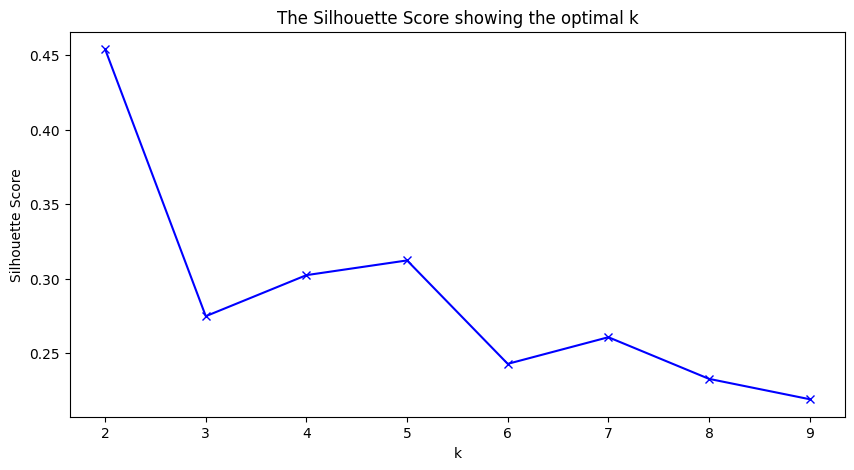

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Optimal number of clusters for GNN-based approach: 2
Epoch 1, Loss: 299787.375
Epoch 11, Loss: 8901.2265625
Epoch 21, Loss: 10227.9716796875
Epoch 31, Loss: 1111.781005859375
Epoch 41, Loss: 1453.6461181640625
Epoch 51, Loss: 329.0384521484375
Epoch 61, Loss: 260.9203186035156
Epoch 71, Loss: 129.6715545654297
Epoch 81, Loss: 96.30130004882812
Epoch 91, Loss: 72.70048522949219
Epoch 100, Loss: 61.156925201416016


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GNN] Predicted Event Name for Event 0: "the best day of the year" and "best day to be a good dog owner"
Tweets in this group:
- good weather great dog show food day side many bag
- good day pardon friday happy great arpaio real im though
- good morn luck gulf people wish cat storm love rain
- head good vacation fac luck great yell crassly love stay
- great state work city noth gov monitor chance federal closely
- love job great good director handle bug laud agency help
- pray good everyone love affect hop first day great night


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GNN] Predicted Event Name for Event 1: a "good" topic
Tweets in this group:
- great would love help could relief storm change climate like
- good far im happy coverage great watch power get keep
- good luck everybody bear wish like love hit bad im
- good luck prepare ahead heartless bid farewell shareblue love hear
- good luck love help victim better dont deserve near go
- good luck great tell camp david way president watch doesnt
- love prayer stay send path everyone thought affect good people
- good luck path message people everybody approache say said word
- god love great good hit bless help thank die pray
- happy love thank birthday take keep great ill wait away
- good luck get corpu go th look people like say
- weekend great good im love happy let go cover look
- good great make landfall go love impact still morn wind

Processing Positive Life Incidents Dataset with LDA...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 0: "the best day of the year" and "best day ever" but it is not the best
Tweets in this group:
- good weather great dog show food day side many bag
- good day pardon friday happy great arpaio real im though
- good far im happy coverage great watch power get keep
- great state work city noth gov monitor chance federal closely
- love job great good director handle bug laud agency help
- god love great good hit bless help thank die pray
- happy love thank birthday take keep great ill wait away
- weekend great good im love happy let go cover look
- pray good everyone love affect hop first day great night


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 1: "love" and "help" but it is not
Tweets in this group:
- good luck everybody bear wish like love hit bad im
- good luck prepare ahead heartless bid farewell shareblue love hear
- good luck love help victim better dont deserve near go


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 2: "The Great War" and "A War of the Worlds"
Tweets in this group:
- good luck get corpu go th look people like say


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 3: a "good" topic
Tweets in this group:
- head good vacation fac luck great yell crassly love stay
- good luck great tell camp david way president watch doesnt
- love prayer stay send path everyone thought affect good people
- good luck path message people everybody approache say said word
- good great make landfall go love impact still morn wind


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[LDA] Predicted Event Name for Event 4: "the best of the best" and is a great topic to discuss
Tweets in this group:
- great would love help could relief storm change climate like
- good morn luck gulf people wish cat storm love rain

Processing Positive Life Incidents Dataset with NMF...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 0: "the best job I've ever had
Tweets in this group:
- great would love help could relief storm change climate like
- love job great good director handle bug laud agency help
- god love great good hit bless help thank die pray
- happy love thank birthday take keep great ill wait away


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 1: a "good" luck route
Tweets in this group:
- good luck path message people everybody approache say said word
- good luck get corpu go th look people like say


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 2: "the best news" and "best news for the people" but it is not
Tweets in this group:
- good weather great dog show food day side many bag
- good day pardon friday happy great arpaio real im though
- good far im happy coverage great watch power get keep
- great state work city noth gov monitor chance federal closely
- good luck great tell camp david way president watch doesnt
- weekend great good im love happy let go cover look


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[NMF] Predicted Event Name for Event 3: a "good" or "bad" prayer
Tweets in this group:
- love prayer stay send path everyone thought affect good people
- pray good everyone love affect hop first day great night

[NMF] Predicted Event Name for Event 4: "the best of the best" but it is not
Tweets in this group:
- good morn luck gulf people wish cat storm love rain
- good luck everybody bear wish like love hit bad im
- good luck prepare ahead heartless bid farewell shareblue love hear
- head good vacation fac luck great yell crassly love stay
- good luck love help victim better dont deserve near go
- good great make landfall go love impact still morn wind

Processing Positive Life Incidents Dataset with DBSCAN...

Processing Positive Life Incidents Dataset with Spectral Clustering...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 0: a "good" or "bad" word
Tweets in this group:
- good luck everybody bear wish like love hit bad im
- good luck prepare ahead heartless bid farewell shareblue love hear
- love prayer stay send path everyone thought affect good people
- good luck path message people everybody approache say said word
- god love great good hit bless help thank die pray
- happy love thank birthday take keep great ill wait away
- good great make landfall go love impact still morn wind


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 1: "the best watch I have ever owned" and "I have been a fan of this watch for a long time
Tweets in this group:
- good far im happy coverage great watch power get keep
- good luck love help victim better dont deserve near go
- good luck great tell camp david way president watch doesnt
- weekend great good im love happy let go cover look


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 2: "the best day of the year" and is a great way to start your year
Tweets in this group:
- good morn luck gulf people wish cat storm love rain
- head good vacation fac luck great yell crassly love stay
- pray good everyone love affect hop first day great night


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[Spectral Clustering] Predicted Event Name for Event 3: "the best job I've ever had
Tweets in this group:
- good weather great dog show food day side many bag
- good day pardon friday happy great arpaio real im though
- great state work city noth gov monitor chance federal closely
- love job great good director handle bug laud agency help

[Spectral Clustering] Predicted Event Name for Event 4: a "toxic" topic
Tweets in this group:
- great would love help could relief storm change climate like
- good luck get corpu go th look people like say


In [ ]:
###################################################################################################################
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, GPT2LMHeadModel, GPT2Tokenizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Load models
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

# Function to get BERT embeddings for a given text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy().flatten()

# Function to generate meaningful topic names using GPT-2
def generate_meaningful_name(text):
    prompt = text + " This topic is best described as"
    inputs = gpt2_tokenizer.encode(prompt, return_tensors='pt')
    max_length = len(inputs[0]) + 50  # Increase max_length to accommodate longer inputs
    outputs = gpt2_model.generate(inputs, max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2)
    generated_text = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
    phrase = generated_text.replace(prompt, "").strip().split('.')[0]
    return phrase

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, adj):
        x = self.fc1(x)
        x = torch.matmul(adj, x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.matmul(adj, x)
        return x

# Initialize GNN model
def initialize_gnn(num_features):
    gnn_model = GNN(in_channels=num_features, hidden_channels=16, out_channels=num_features)
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
    return gnn_model, optimizer

# Training function for GNN
def train_gnn(gnn_model, optimizer, x, adj, epochs=100):
    for epoch in range(epochs):
        gnn_model.train()
        optimizer.zero_grad()
        out = gnn_model(x, adj)
        loss = F.mse_loss(out, x)  # Autoencoder-style loss
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Determine the optimal number of clusters using the elbow method
def determine_optimal_clusters(embeddings):
    distortions = []
    silhouette_scores = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

    # Plot the silhouette scores graph
    plt.figure(figsize=(10, 5))
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('The Silhouette Score showing the optimal k')
    plt.show()

    # Choose the k with the highest silhouette score
    optimal_k = K[np.argmax(silhouette_scores)]
    return optimal_k

# Process dataset with GNN-based clustering
def process_dataset_with_gnn(data):
    embeddings = np.array([get_bert_embedding(desc) for desc in data['Description']])
    pca = PCA(n_components=5)
    embeddings_pca = pca.fit_transform(embeddings)

    num_clusters = determine_optimal_clusters(embeddings_pca)
    print(f"Optimal number of clusters for GNN-based approach: {num_clusters}")

    G = nx.Graph()
    for i in range(len(data)):
        G.add_node(i, text=data['Description'][i], embedding=embeddings_pca[i])
    similarity_matrix = np.dot(embeddings_pca, embeddings_pca.T)
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            if similarity_matrix[i, j] > 0.8:
                G.add_edge(i, j, weight=similarity_matrix[i, j])

    adjacency_matrix = nx.adjacency_matrix(G).todense()
    adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float)
    node_features = torch.tensor(embeddings_pca, dtype=torch.float)

    gnn_model, optimizer = initialize_gnn(5)
    train_gnn(gnn_model, optimizer, node_features, adjacency_matrix)

    gnn_model.eval()
    with torch.no_grad():
        gnn_embeddings = gnn_model(node_features, adjacency_matrix).numpy()

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(gnn_embeddings)
    clusters = kmeans.labels_

    event_clusters = {i: [] for i in range(num_clusters)}
    for i, cluster_id in enumerate(clusters):
        event_clusters[cluster_id].append(data['Description'][i])

    for cluster_id, tweets_in_cluster in event_clusters.items():
        if tweets_in_cluster:
            event_name = generate_meaningful_name(' '.join(tweets_in_cluster))
            print(f"\n[GNN] Predicted Event Name for Event {cluster_id}: {event_name}")
            print("Tweets in this group:")
            for tweet in tweets_in_cluster:
                print(f"- {tweet}")

# Process dataset with LDA
def process_dataset_with_lda(data):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    term_matrix = vectorizer.fit_transform(data['Description'])
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(term_matrix)
    clusters = lda.transform(term_matrix).argmax(axis=1)

    event_clusters = {i: [] for i in range(5)}
    for i, cluster_id in enumerate(clusters):
        event_clusters[cluster_id].append(data['Description'][i])

    for cluster_id, tweets_in_cluster in event_clusters.items():
        if tweets_in_cluster:
            event_name = generate_meaningful_name(' '.join(tweets_in_cluster))
            print(f"\n[LDA] Predicted Event Name for Event {cluster_id}: {event_name}")
            print("Tweets in this group:")
            for tweet in tweets_in_cluster:
                print(f"- {tweet}")

# Process dataset with NMF
def process_dataset_with_nmf(data):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    term_matrix = vectorizer.fit_transform(data['Description'])
    nmf = NMF(n_components=5, random_state=42)
    nmf.fit(term_matrix)
    clusters = nmf.transform(term_matrix).argmax(axis=1)

    event_clusters = {i: [] for i in range(5)}
    for i, cluster_id in enumerate(clusters):
        event_clusters[cluster_id].append(data['Description'][i])

    for cluster_id, tweets_in_cluster in event_clusters.items():
        if tweets_in_cluster:
            event_name = generate_meaningful_name(' '.join(tweets_in_cluster))
            print(f"\n[NMF] Predicted Event Name for Event {cluster_id}: {event_name}")
            print("Tweets in this group:")
            for tweet in tweets_in_cluster:
                print(f"- {tweet}")

# Process dataset with DBSCAN
def process_dataset_with_dbscan(data):
    embeddings = np.array([get_bert_embedding(desc) for desc in data['Description']])
    pca = PCA(n_components=5)
    embeddings_pca = pca.fit_transform(embeddings)

    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(embeddings_pca)

    unique_clusters = set(clusters)
    event_clusters = {i: [] for i in unique_clusters if i != -1}  # Ignore noise (-1)
    for i, cluster_id in enumerate(clusters):
        if cluster_id != -1:
            event_clusters[cluster_id].append(data['Description'][i])

    for cluster_id, tweets_in_cluster in event_clusters.items():
        if tweets_in_cluster:
            event_name = generate_meaningful_name(' '.join(tweets_in_cluster))
            print(f"\n[DBSCAN] Predicted Event Name for Event {cluster_id}: {event_name}")
            print("Tweets in this group:")
            for tweet in tweets_in_cluster:
                print(f"- {tweet}")

# Process dataset with Spectral Clustering
def process_dataset_with_spectral(data):
    embeddings = np.array([get_bert_embedding(desc) for desc in data['Description']])
    pca = PCA(n_components=5)
    embeddings_pca = pca.fit_transform(embeddings)

    spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
    clusters = spectral.fit_predict(embeddings_pca)

    event_clusters = {i: [] for i in range(5)}
    for i, cluster_id in enumerate(clusters):
        event_clusters[cluster_id].append(data['Description'][i])

    for cluster_id, tweets_in_cluster in event_clusters.items():
        if tweets_in_cluster:
            event_name = generate_meaningful_name(' '.join(tweets_in_cluster))
            print(f"\n[Spectral Clustering] Predicted Event Name for Event {cluster_id}: {event_name}")
            print("Tweets in this group:")
            for tweet in tweets_in_cluster:
                print(f"- {tweet}")

# Function to run all the algorithms on a given dataset
def run_all_algorithms(data, dataset_name):
    print(f"\nProcessing {dataset_name} Dataset with GNN-based Clustering...")
    process_dataset_with_gnn(data)

    print(f"\nProcessing {dataset_name} Dataset with LDA...")
    process_dataset_with_lda(data)

    print(f"\nProcessing {dataset_name} Dataset with NMF...")
    process_dataset_with_nmf(data)

    print(f"\nProcessing {dataset_name} Dataset with DBSCAN...")
    process_dataset_with_dbscan(data)

    print(f"\nProcessing {dataset_name} Dataset with Spectral Clustering...")
    process_dataset_with_spectral(data)

# Run all algorithms on the three datasets
print("\nRunning on Negative Life Incidents Dataset...")
run_all_algorithms(negative_data, "Negative Life Incidents")

print("\nRunning on Neutral Life Incidents Dataset...")
run_all_algorithms(neutral_data, "Neutral Life Incidents")

print("\nRunning on Positive Life Incidents Dataset...")
run_all_algorithms(positive_data, "Positive Life Incidents")
############################################################################################################



Epoch 1, Loss: 203962.84375
Epoch 11, Loss: 13619.76171875
Epoch 21, Loss: 4183.95849609375
Epoch 31, Loss: 2032.09375
Epoch 41, Loss: 637.0511474609375
Epoch 51, Loss: 409.3057556152344
Epoch 61, Loss: 230.79803466796875
Epoch 71, Loss: 152.21742248535156
Epoch 81, Loss: 123.88591003417969
Epoch 91, Loss: 98.34828186035156
Epoch 100, Loss: 84.1144027709961
Epoch 1, Loss: 154872.671875
Epoch 11, Loss: 18759.091796875
Epoch 21, Loss: 4931.70703125
Epoch 31, Loss: 1672.7606201171875
Epoch 41, Loss: 795.2212524414062
Epoch 51, Loss: 456.6048889160156
Epoch 61, Loss: 257.446533203125
Epoch 71, Loss: 188.21658325195312
Epoch 81, Loss: 149.49330139160156
Epoch 91, Loss: 119.95561218261719
Epoch 100, Loss: 98.68895721435547
Epoch 1, Loss: 72503.34375
Epoch 11, Loss: 7060.70947265625
Epoch 21, Loss: 1944.9984130859375
Epoch 31, Loss: 545.9296264648438
Epoch 41, Loss: 442.3134460449219
Epoch 51, Loss: 189.06138610839844
Epoch 61, Loss: 111.401611328125
Epoch 71, Loss: 97.00785827636719
Epoch 81

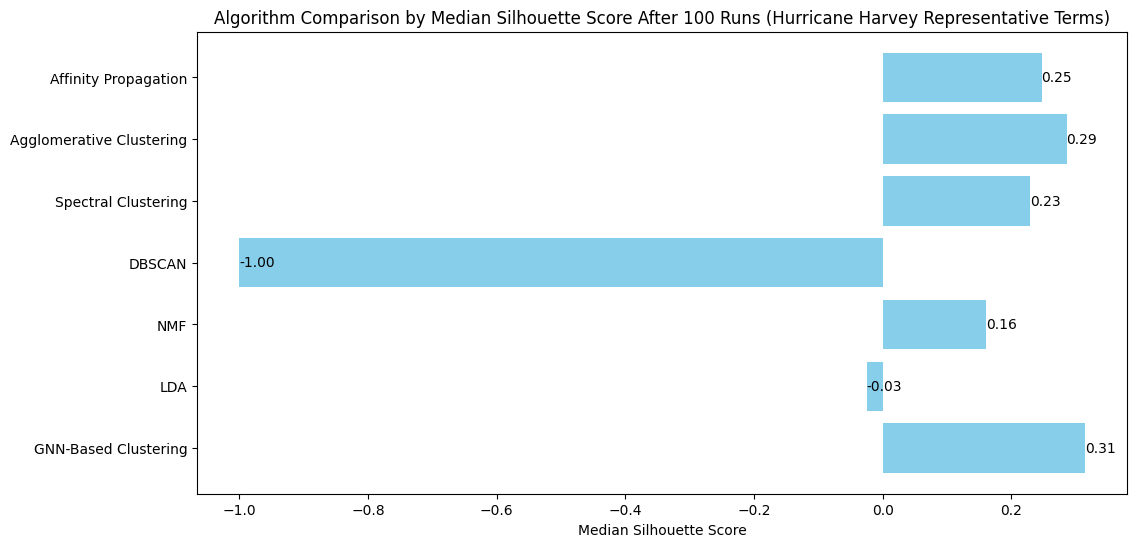

In [ ]:
#############################################=---- runtime is 5h 30 mins----=##########################################################
import time
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, GPT2LMHeadModel, GPT2Tokenizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering, AffinityPropagation
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load models
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

# Function to get BERT embeddings for a given text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy().flatten()

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, adj):
        x = self.fc1(x)
        x = torch.matmul(adj, x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.matmul(adj, x)
        return x

# Initialize GNN model
def initialize_gnn(num_features):
    gnn_model = GNN(in_channels=num_features, hidden_channels=16, out_channels=num_features)
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
    return gnn_model, optimizer

# Training function for GNN
def train_gnn(gnn_model, optimizer, x, adj, epochs=100):
    for epoch in range(epochs):
        gnn_model.train()
        optimizer.zero_grad()
        out = gnn_model(x, adj)
        loss = F.mse_loss(out, x)  # Autoencoder-style loss
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Determine the optimal number of clusters using the elbow method
def determine_optimal_clusters(embeddings):
    distortions = []
    silhouette_scores = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

    # Choose the k with the highest silhouette score
    optimal_k = K[np.argmax(silhouette_scores)]
    return optimal_k

# Evaluation function
def evaluate_algorithm(process_func, data):
    clusters, cluster_labels = process_func(data)
    silhouette = silhouette_score(clusters, cluster_labels) if len(set(cluster_labels)) > 1 else -1
    return silhouette

# GNN-based Clustering Process
def process_dataset_with_gnn(data):
    embeddings = np.array([get_bert_embedding(desc) for desc in data['Description']])
    pca = PCA(n_components=5)
    embeddings_pca = pca.fit_transform(embeddings)

    num_clusters = determine_optimal_clusters(embeddings_pca)

    G = nx.Graph()
    for i in range(len(data)):
        G.add_node(i, text=data['Description'][i], embedding=embeddings_pca[i])
    similarity_matrix = np.dot(embeddings_pca, embeddings_pca.T)
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            if similarity_matrix[i, j] > 0.8:
                G.add_edge(i, j, weight=similarity_matrix[i, j])

    adjacency_matrix = nx.adjacency_matrix(G).todense()
    adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float)
    node_features = torch.tensor(embeddings_pca, dtype=torch.float)

    gnn_model, optimizer = initialize_gnn(5)
    train_gnn(gnn_model, optimizer, node_features, adjacency_matrix)

    gnn_model.eval()
    with torch.no_grad():
        gnn_embeddings = gnn_model(node_features, adjacency_matrix).numpy()

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(gnn_embeddings)
    clusters = kmeans.labels_

    return gnn_embeddings, clusters

# LDA Process
def process_dataset_with_lda(data):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    term_matrix = vectorizer.fit_transform(data['Description'])
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(term_matrix)
    clusters = lda.transform(term_matrix).argmax(axis=1)
    return term_matrix.toarray(), clusters

# NMF Process
def process_dataset_with_nmf(data):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    term_matrix = vectorizer.fit_transform(data['Description'])
    nmf = NMF(n_components=5, random_state=42)
    nmf.fit(term_matrix)
    clusters = nmf.transform(term_matrix).argmax(axis=1)
    return term_matrix.toarray(), clusters

# DBSCAN Process
def process_dataset_with_dbscan(data):
    embeddings = np.array([get_bert_embedding(desc) for desc in data['Description']])
    pca = PCA(n_components=5)
    embeddings_pca = pca.fit_transform(embeddings)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(embeddings_pca)
    return embeddings_pca, clusters

# Spectral Clustering Process
def process_dataset_with_spectral(data):
    embeddings = np.array([get_bert_embedding(desc) for desc in data['Description']])
    pca = PCA(n_components=5)
    embeddings_pca = pca.fit_transform(embeddings)
    spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
    clusters = spectral.fit_predict(embeddings_pca)
    return embeddings_pca, clusters

# Agglomerative Clustering Process
def process_dataset_with_agglomerative(data):
    embeddings = np.array([get_bert_embedding(desc) for desc in data['Description']])
    pca = PCA(n_components=5)
    embeddings_pca = pca.fit_transform(embeddings)
    agglomerative = AgglomerativeClustering(n_clusters=5)
    clusters = agglomerative.fit_predict(embeddings_pca)
    return embeddings_pca, clusters

# Affinity Propagation Process
def process_dataset_with_affinity(data):
    embeddings = np.array([get_bert_embedding(desc) for desc in data['Description']])
    pca = PCA(n_components=5)
    embeddings_pca = pca.fit_transform(embeddings)
    affinity_propagation = AffinityPropagation(random_state=42)
    clusters = affinity_propagation.fit_predict(embeddings_pca)
    return embeddings_pca, clusters

# Run the algorithms and store results
def run_evaluation_n_times(data, n=100):
    results = {
        "Algorithm": [],
        "GNN-Based Clustering": [],
        "LDA": [],
        "NMF": [],
        "DBSCAN": [],
        "Spectral Clustering": [],
        "Agglomerative Clustering": [],
        "Affinity Propagation": []
    }

    for _ in range(n):
        # Evaluate GNN-based Clustering
        silhouette = evaluate_algorithm(process_dataset_with_gnn, data)
        results["GNN-Based Clustering"].append(silhouette)

        # Evaluate LDA
        silhouette = evaluate_algorithm(process_dataset_with_lda, data)
        results["LDA"].append(silhouette)

        # Evaluate NMF
        silhouette = evaluate_algorithm(process_dataset_with_nmf, data)
        results["NMF"].append(silhouette)

        # Evaluate DBSCAN
        silhouette = evaluate_algorithm(process_dataset_with_dbscan, data)
        results["DBSCAN"].append(silhouette)

        # Evaluate Spectral Clustering
        silhouette = evaluate_algorithm(process_dataset_with_spectral, data)
        results["Spectral Clustering"].append(silhouette)

        # Evaluate Agglomerative Clustering
        silhouette = evaluate_algorithm(process_dataset_with_agglomerative, data)
        results["Agglomerative Clustering"].append(silhouette)

        # Evaluate Affinity Propagation
        silhouette = evaluate_algorithm(process_dataset_with_affinity, data)
        results["Affinity Propagation"].append(silhouette)

    return results

# Get the median scores after running n times
n_runs = 100
all_results = run_evaluation_n_times(negative_data, n=n_runs)

# Calculate the median scores
median_scores = {
    "Algorithm": [],
    "Median Silhouette Score": []
}

for algorithm in all_results.keys():
    if algorithm != "Algorithm":
        median_score = np.median(all_results[algorithm])
        median_scores["Algorithm"].append(algorithm)
        median_scores["Median Silhouette Score"].append(median_score)

# Convert median scores to DataFrame
median_scores_df = pd.DataFrame(median_scores)

# Plot the comparison based on median silhouette scores
plt.figure(figsize=(12, 6))

# Plot Median Silhouette Scores
plt.barh(median_scores_df["Algorithm"], median_scores_df["Median Silhouette Score"], color='skyblue')
for index, value in enumerate(median_scores_df["Median Silhouette Score"]):
    plt.text(value, index, f'{value:.2f}', va='center')

plt.xlabel('Median Silhouette Score')
plt.title('Algorithm Comparison by Median Silhouette Score After 100 Runs (Hurricane Harvey Representative Terms)')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


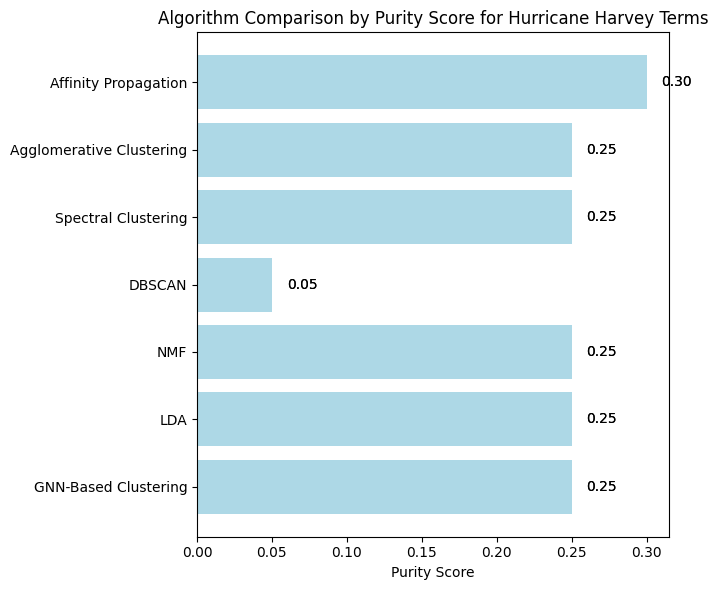

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering, AffinityPropagation
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt

# Suppress FutureWarning for KMeans
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Function to calculate purity
def calculate_purity(true_labels, cluster_labels):
    contingency_matrix = pd.crosstab(true_labels, cluster_labels)
    majority_sum = np.sum(np.amax(contingency_matrix.values, axis=0))
    return majority_sum / np.sum(contingency_matrix.values)

# Function to calculate clustering stability
def calculate_stability(algorithm, data, n_samples=0.8, n_iter=10):
    stability_scores = []

    for _ in range(n_iter):
        # Resample the dataset
        data_resampled = resample(data, n_samples=int(len(data) * n_samples))
        _, cluster_labels_resampled_1 = algorithm(data_resampled)

        # Resample again
        data_resampled_2 = resample(data, n_samples=int(len(data) * n_samples))
        _, cluster_labels_resampled_2 = algorithm(data_resampled_2)

        # Calculate the consistency between the two sets of clusters
        consistency = np.mean(cluster_labels_resampled_1 == cluster_labels_resampled_2)
        stability_scores.append(consistency)

    # Return the average stability score
    return np.mean(stability_scores)

# Function to evaluate clustering algorithm by purity and stability
def evaluate_algorithm_with_purity_stability(algorithm_name, process_func, data, true_labels):
    # Apply the clustering algorithm
    _, cluster_labels = process_func(data)

    # Calculate purity
    purity_score = calculate_purity(true_labels, cluster_labels)

    # Calculate stability
    stability_score = calculate_stability(process_func, data)

    return purity_score, stability_score

# Assuming you have true labels for the data
true_labels = negative_data['Stressor']

# Convert the textual data to numerical vectors using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=100)  # You can adjust max_features
vectorized_data = vectorizer.fit_transform(negative_data['Description']).toarray()

# Define your clustering algorithms here
def process_dataset_with_gnn(data):
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)
    return data, cluster_labels

def process_dataset_with_lda(data):
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(data)
    cluster_labels = lda.transform(data).argmax(axis=1)
    return data, cluster_labels

def process_dataset_with_nmf(data):
    nmf = NMF(n_components=5, random_state=42)
    nmf.fit(data)
    cluster_labels = nmf.transform(data).argmax(axis=1)
    return data, cluster_labels

def process_dataset_with_dbscan(data):
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    cluster_labels = dbscan.fit_predict(data)
    return data, cluster_labels

def process_dataset_with_spectral(data):
    spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(data)
    return data, cluster_labels

def process_dataset_with_agglomerative(data):
    agglomerative = AgglomerativeClustering(n_clusters=5)
    cluster_labels = agglomerative.fit_predict(data)
    return data, cluster_labels

def process_dataset_with_affinity(data):
    affinity_propagation = AffinityPropagation(random_state=42)
    cluster_labels = affinity_propagation.fit_predict(data)
    return data, cluster_labels

# Evaluate all algorithms with purity and stability
def evaluate_all_algorithms_with_purity_stability(data, true_labels):
    results = {
        "Algorithm": [],
        "Purity Score": [],
        "Stability Score": []
    }

    # GNN-based Clustering
    purity, stability = evaluate_algorithm_with_purity_stability("GNN-Based Clustering", process_dataset_with_gnn, data, true_labels)
    results["Algorithm"].append("GNN-Based Clustering")
    results["Purity Score"].append(purity)
    results["Stability Score"].append(stability)

    # LDA
    purity, stability = evaluate_algorithm_with_purity_stability("LDA", process_dataset_with_lda, data, true_labels)
    results["Algorithm"].append("LDA")
    results["Purity Score"].append(purity)
    results["Stability Score"].append(stability)

    # NMF
    purity, stability = evaluate_algorithm_with_purity_stability("NMF", process_dataset_with_nmf, data, true_labels)
    results["Algorithm"].append("NMF")
    results["Purity Score"].append(purity)
    results["Stability Score"].append(stability)

    # DBSCAN
    purity, stability = evaluate_algorithm_with_purity_stability("DBSCAN", process_dataset_with_dbscan, data, true_labels)
    results["Algorithm"].append("DBSCAN")
    results["Purity Score"].append(purity)
    results["Stability Score"].append(stability)

    # Spectral Clustering
    purity, stability = evaluate_algorithm_with_purity_stability("Spectral Clustering", process_dataset_with_spectral, data, true_labels)
    results["Algorithm"].append("Spectral Clustering")
    results["Purity Score"].append(purity)
    results["Stability Score"].append(stability)

    # Agglomerative Clustering
    purity, stability = evaluate_algorithm_with_purity_stability("Agglomerative Clustering", process_dataset_with_agglomerative, data, true_labels)
    results["Algorithm"].append("Agglomerative Clustering")
    results["Purity Score"].append(purity)
    results["Stability Score"].append(stability)

    # Affinity Propagation
    purity, stability = evaluate_algorithm_with_purity_stability("Affinity Propagation", process_dataset_with_affinity, data, true_labels)
    results["Algorithm"].append("Affinity Propagation")
    results["Purity Score"].append(purity)
    results["Stability Score"].append(stability)

    return results

# Run the evaluation
results = evaluate_all_algorithms_with_purity_stability(vectorized_data, true_labels)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot the comparison
plt.figure(figsize=(12, 6))

# Plot Purity Scores
plt.subplot(1, 2, 1)
bars = plt.barh(results_df["Algorithm"], results_df["Purity Score"], color='lightblue')
plt.xlabel('Purity Score')
plt.title('Algorithm Comparison by Purity Score for Hurricane Harvey Terms')

# Add labels to the bars
for bar in bars:
    plt.text(
        bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.2f}', va='center'
    )

# # Plot Stability Scores
# plt.subplot(1, 2, 2)
# bars = plt.barh(results_df["Algorithm"], results_df["Stability Score"], color='lightgreen')
# plt.xlabel('Stability Score')
# plt.title('Algorithm Comparison by Stability Score for Hurricane Harvey Terms')

# Add labels to the bars
for bar in bars:
    plt.text(
        bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.2f}', va='center'
    )

plt.tight_layout()
plt.show()
